In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import layers

2024-02-21 05:13:55.560946: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 05:13:55.561032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 05:13:55.691327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images.shape

4422102/4422102 [==============================] - 1s 0us/step


(60000, 28, 28)

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_images.shape

(60000, 28, 28, 1)

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [18]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, input_shape=(100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((7, 7, 256)))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))
    
    return model

In [19]:
generator = generator_model()

generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12544)             1266944   
                                                                 
 batch_normalization_8 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 7, 7, 128)         819328    
 Transpose)                                                      
                                                                 
 batch_normalization_9 (Bat  (None, 7, 7, 128)        

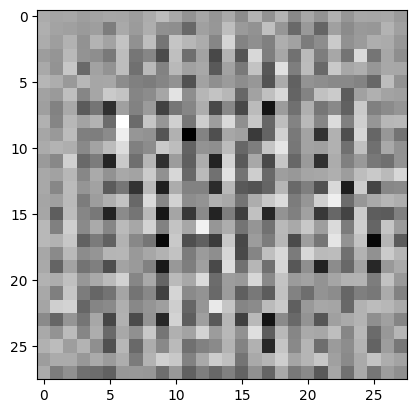

In [20]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [21]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [22]:
discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_11 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_12 (Ba  (None, 7, 7, 128)         512       
 tchNormalization)                                    

In [23]:
output = discriminator(generated_image)
print(output)

tf.Tensor([[0.49951673]], shape=(1, 1), dtype=float32)


In [24]:
bce = tf.keras.losses.BinaryCrossentropy()

In [25]:
def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [26]:
def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [28]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

In [29]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal((num_examples_to_generate, noise_dim))

In [30]:
def generate_and_plot_images(model, epoch, test_input):
    predictions = model(test_input)
    fig = plt.figure(figsize=(8, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        pred = (predictions[i, :, :, 0] + 1) * 127.5
        pred = np.array(pred)
        plt.imshow(pred.astype(np.uint8), cmap='gray')
        plt.axis('off')
    
    plt.savefig(f'image_at_epoch_{epoch+1:04d}.png')
    plt.show()

In [34]:
@tf.function
def train_step(images):
    noise = tf.random.normal((BATCH_SIZE, noise_dim))
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output)

In [35]:
def train(dataset, epochs):
    gen_loss_list, disc_loss_list = [], []
    real_score_list, fake_score_list = [], []
    
    for epoch in tqdm(range(epochs)):
        start = time.time()
        num_batches = len(dataset)
        
        print(f'Training started with epoch {epoch+1} with {num_batches} batches')
        
        total_gen_loss, total_disc_loss = 0, 0
        
        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss
            
        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches
        
        print(f'Losses after epoch {epoch+1:5d}: generator: {generator_loss:.3f}, discriminator: {discriminator_loss:.3f}, real_score: {real_score+100}, fake_score: {fake_score*100}')
        
        generate_and_plot_images(generator, epoch+1, seed)
        
        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)
        
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        print(f'Time for epoch {epoch+1}: {time.time()-start}')
    
    return gen_loss_list, disc_loss_list, real_score_list, fake_score_list

  0%|          | 0/50 [00:00<?, ?it/s]

Training started with epoch 1 with 469 batches


2024-02-21 05:53:09.213449: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708494792.134134     465 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Losses after epoch     1: generator: 1.885, discriminator: 0.668, real_score: 100.73233795166016, fake_score: 20.510927200317383


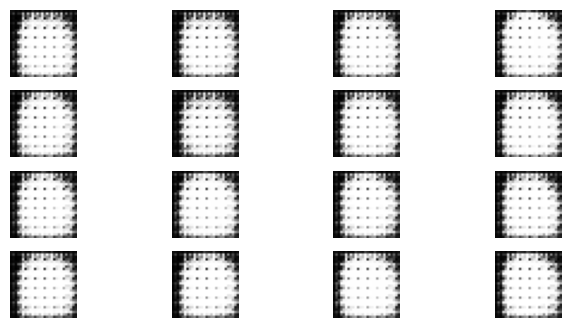

  2%|▏         | 1/50 [00:16<13:23, 16.41s/it]

Time for epoch 1: 16.40605115890503
Training started with epoch 2 with 469 batches
Losses after epoch     2: generator: 1.649, discriminator: 0.724, real_score: 100.72960662841797, fake_score: 25.764339447021484


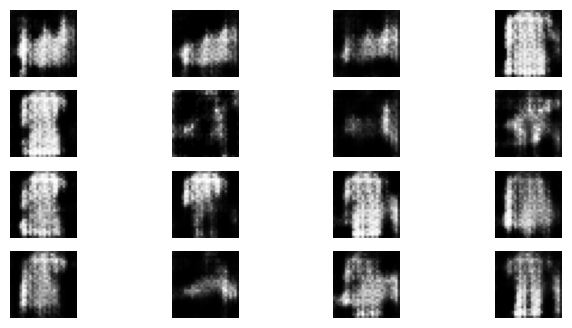

  4%|▍         | 2/50 [00:24<09:21, 11.71s/it]

Time for epoch 2: 8.416456937789917
Training started with epoch 3 with 469 batches
Losses after epoch     3: generator: 1.201, discriminator: 0.975, real_score: 100.69618225097656, fake_score: 37.36167907714844


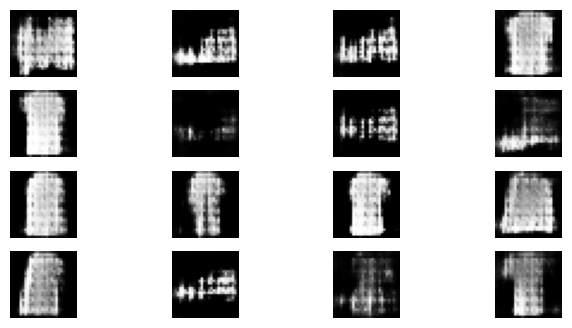

  6%|▌         | 3/50 [00:33<07:59, 10.20s/it]

Time for epoch 3: 8.414148330688477
Training started with epoch 4 with 469 batches
Losses after epoch     4: generator: 1.800, discriminator: 1.178, real_score: 100.4784927368164, fake_score: 23.120609283447266


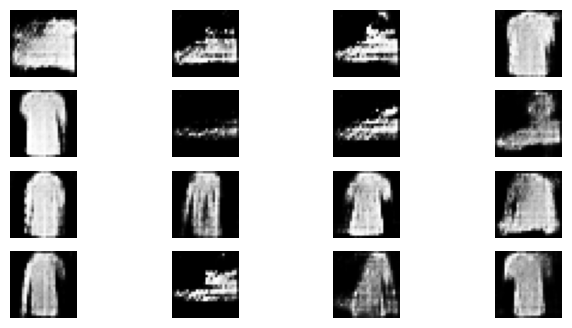

  8%|▊         | 4/50 [00:42<07:28,  9.74s/it]

Time for epoch 4: 9.03711462020874
Training started with epoch 5 with 469 batches
Losses after epoch     5: generator: 1.066, discriminator: 1.256, real_score: 100.59026336669922, fake_score: 41.08354568481445


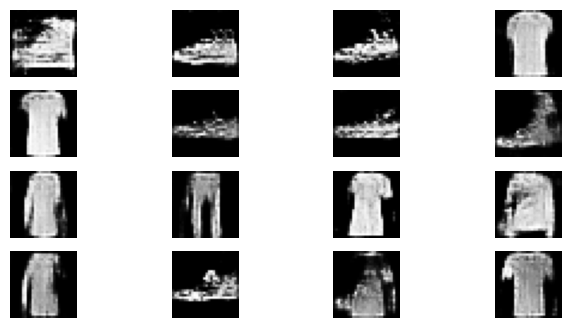

 10%|█         | 5/50 [00:50<06:56,  9.26s/it]

Time for epoch 5: 8.40016222000122
Training started with epoch 6 with 469 batches
Losses after epoch     6: generator: 1.100, discriminator: 1.249, real_score: 100.56338500976562, fake_score: 39.17108917236328


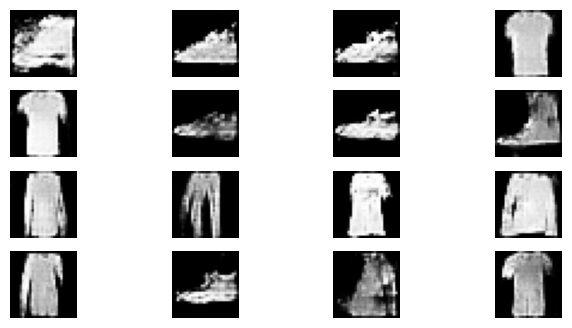

 12%|█▏        | 6/50 [00:59<06:34,  8.97s/it]

Time for epoch 6: 8.401492357254028
Training started with epoch 7 with 469 batches
Losses after epoch     7: generator: 1.053, discriminator: 1.163, real_score: 100.60801696777344, fake_score: 40.1321907043457


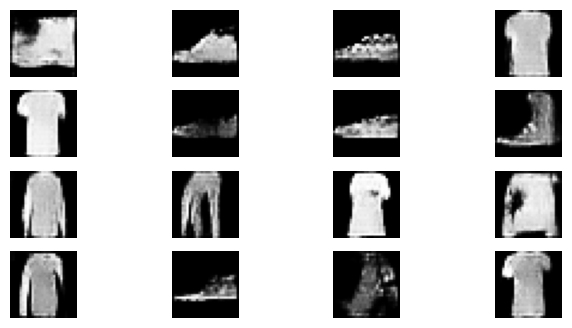

 14%|█▍        | 7/50 [01:07<06:17,  8.77s/it]

Time for epoch 7: 8.364298820495605
Training started with epoch 8 with 469 batches
Losses after epoch     8: generator: 1.101, discriminator: 1.505, real_score: 100.42407989501953, fake_score: 37.99105453491211


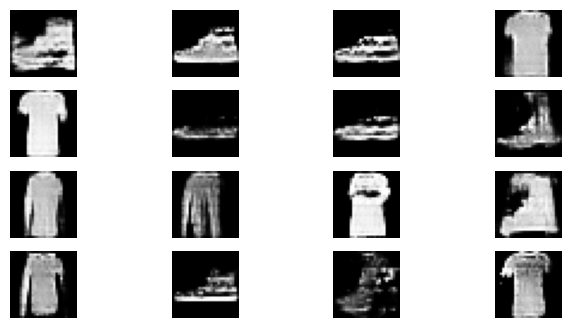

 16%|█▌        | 8/50 [01:15<06:03,  8.66s/it]

Time for epoch 8: 8.422298192977905
Training started with epoch 9 with 469 batches
Losses after epoch     9: generator: 1.088, discriminator: 1.172, real_score: 100.57628631591797, fake_score: 38.87293243408203


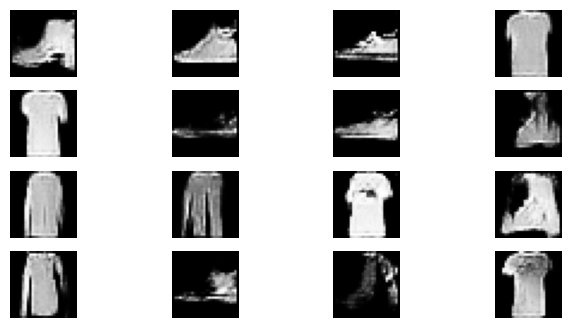

 18%|█▊        | 9/50 [01:24<05:51,  8.57s/it]

Time for epoch 9: 8.360809803009033
Training started with epoch 10 with 469 batches
Losses after epoch    10: generator: 0.642, discriminator: 1.318, real_score: 100.718505859375, fake_score: 56.203125


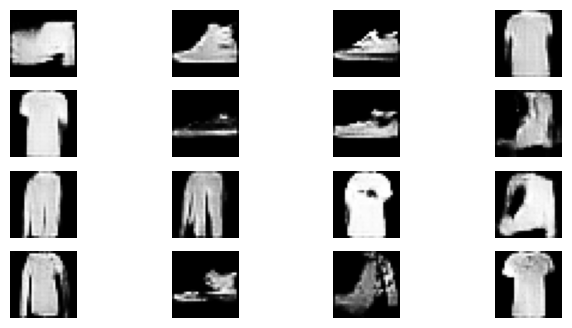

 20%|██        | 10/50 [01:32<05:42,  8.55s/it]

Time for epoch 10: 8.523706912994385
Training started with epoch 11 with 469 batches
Losses after epoch    11: generator: 1.227, discriminator: 1.192, real_score: 100.49925231933594, fake_score: 33.139617919921875


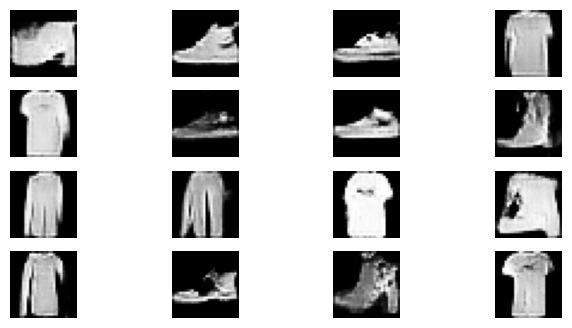

 22%|██▏       | 11/50 [01:41<05:31,  8.51s/it]

Time for epoch 11: 8.395995140075684
Training started with epoch 12 with 469 batches
Losses after epoch    12: generator: 1.454, discriminator: 1.282, real_score: 100.43939971923828, fake_score: 27.762598037719727


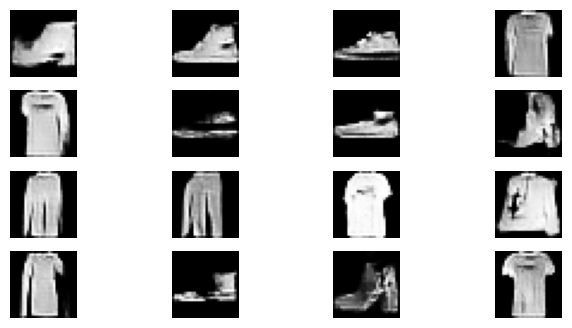

 24%|██▍       | 12/50 [01:49<05:21,  8.46s/it]

Time for epoch 12: 8.33928370475769
Training started with epoch 13 with 469 batches
Losses after epoch    13: generator: 0.821, discriminator: 1.363, real_score: 100.55780029296875, fake_score: 47.57731628417969


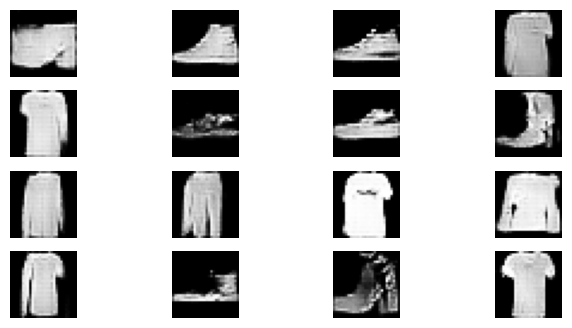

 26%|██▌       | 13/50 [01:57<05:11,  8.41s/it]

Time for epoch 13: 8.31769847869873
Training started with epoch 14 with 469 batches
Losses after epoch    14: generator: 0.878, discriminator: 1.314, real_score: 100.55621337890625, fake_score: 45.11716842651367


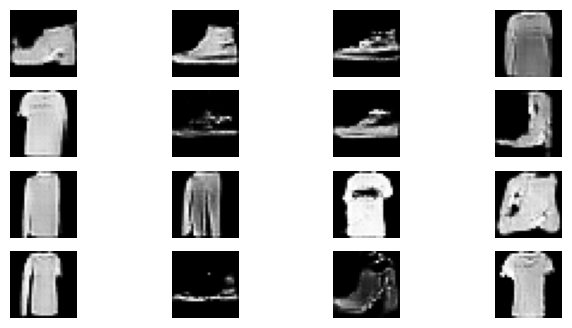

 28%|██▊       | 14/50 [02:06<05:10,  8.62s/it]

Time for epoch 14: 9.091423273086548
Training started with epoch 15 with 469 batches
Losses after epoch    15: generator: 1.096, discriminator: 1.188, real_score: 100.53999328613281, fake_score: 37.495521545410156


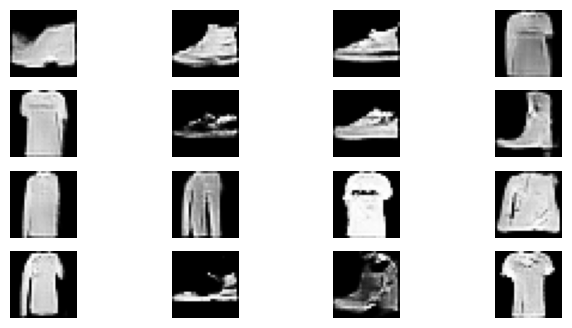

 30%|███       | 15/50 [02:15<04:58,  8.53s/it]

Time for epoch 15: 8.319491624832153
Training started with epoch 16 with 469 batches
Losses after epoch    16: generator: 0.785, discriminator: 1.380, real_score: 100.55181121826172, fake_score: 48.7241096496582


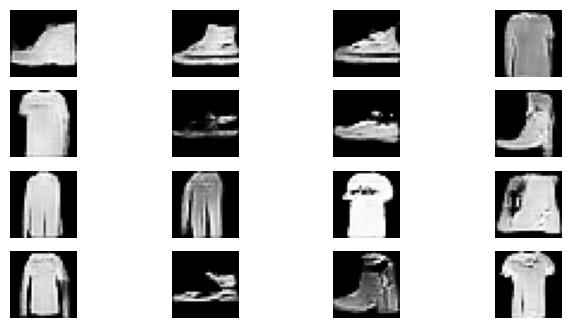

 32%|███▏      | 16/50 [02:23<04:48,  8.47s/it]

Time for epoch 16: 8.343913793563843
Training started with epoch 17 with 469 batches
Losses after epoch    17: generator: 0.819, discriminator: 1.388, real_score: 100.52155303955078, fake_score: 46.50959396362305


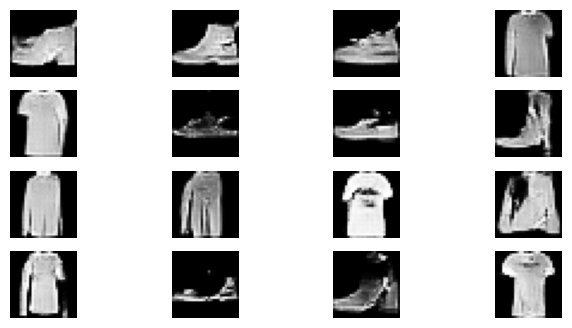

 34%|███▍      | 17/50 [02:31<04:38,  8.44s/it]

Time for epoch 17: 8.349026441574097
Training started with epoch 18 with 469 batches
Losses after epoch    18: generator: 0.892, discriminator: 1.331, real_score: 100.52635192871094, fake_score: 44.43352127075195


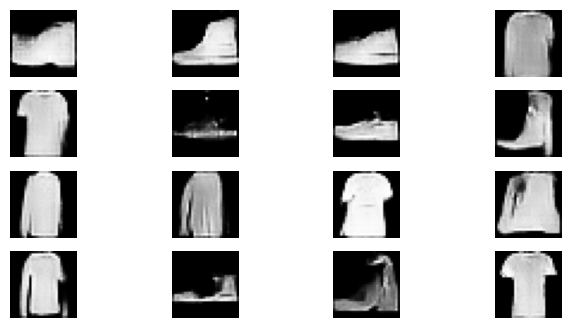

 36%|███▌      | 18/50 [02:40<04:29,  8.42s/it]

Time for epoch 18: 8.370849132537842
Training started with epoch 19 with 469 batches
Losses after epoch    19: generator: 0.818, discriminator: 1.222, real_score: 100.60610961914062, fake_score: 46.855979919433594


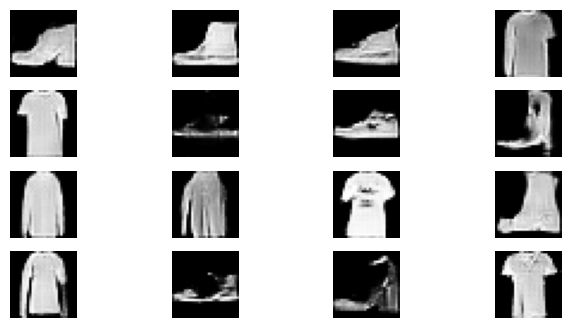

 38%|███▊      | 19/50 [02:48<04:20,  8.39s/it]

Time for epoch 19: 8.339720249176025
Training started with epoch 20 with 469 batches
Losses after epoch    20: generator: 1.094, discriminator: 1.252, real_score: 100.49763488769531, fake_score: 37.59720230102539


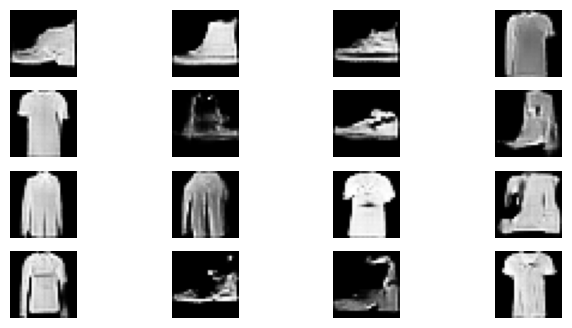

 40%|████      | 20/50 [02:57<04:12,  8.41s/it]

Time for epoch 20: 8.429701566696167
Training started with epoch 21 with 469 batches
Losses after epoch    21: generator: 0.688, discriminator: 1.328, real_score: 100.60368347167969, fake_score: 52.374778747558594


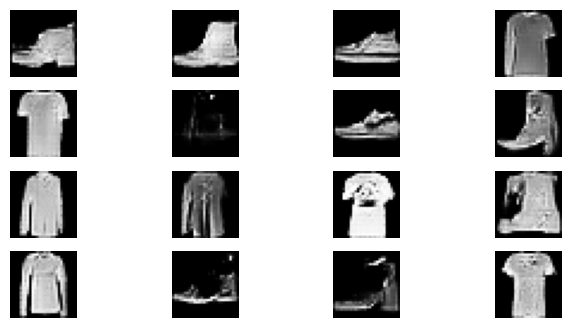

 42%|████▏     | 21/50 [03:05<04:02,  8.38s/it]

Time for epoch 21: 8.30447244644165
Training started with epoch 22 with 469 batches
Losses after epoch    22: generator: 0.896, discriminator: 1.209, real_score: 100.57755279541016, fake_score: 43.46963119506836


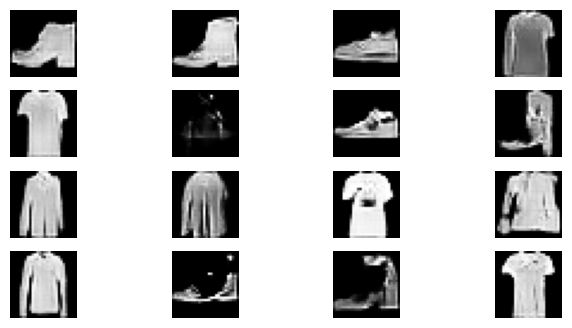

 44%|████▍     | 22/50 [03:13<03:53,  8.35s/it]

Time for epoch 22: 8.292927265167236
Training started with epoch 23 with 469 batches
Losses after epoch    23: generator: 0.930, discriminator: 1.276, real_score: 100.52373504638672, fake_score: 42.41495895385742


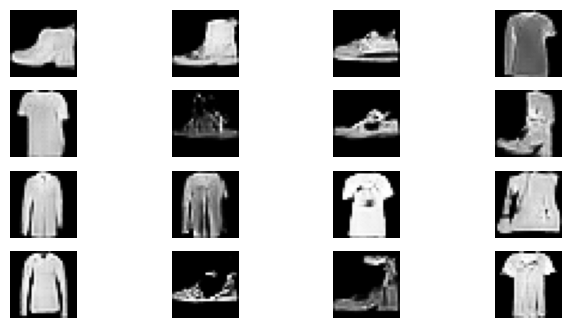

 46%|████▌     | 23/50 [03:22<03:51,  8.56s/it]

Time for epoch 23: 9.035106420516968
Training started with epoch 24 with 469 batches
Losses after epoch    24: generator: 0.989, discriminator: 1.246, real_score: 100.52580261230469, fake_score: 39.98353576660156


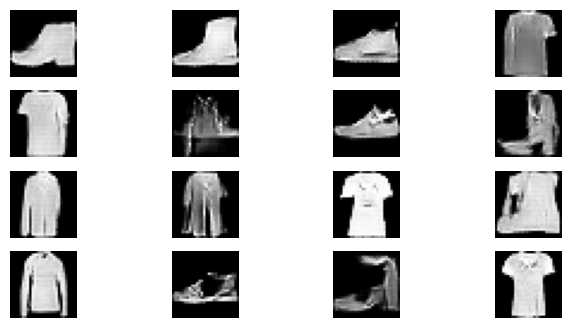

 48%|████▊     | 24/50 [03:31<03:40,  8.49s/it]

Time for epoch 24: 8.328052997589111
Training started with epoch 25 with 469 batches
Losses after epoch    25: generator: 1.047, discriminator: 1.298, real_score: 100.47956848144531, fake_score: 37.87716293334961


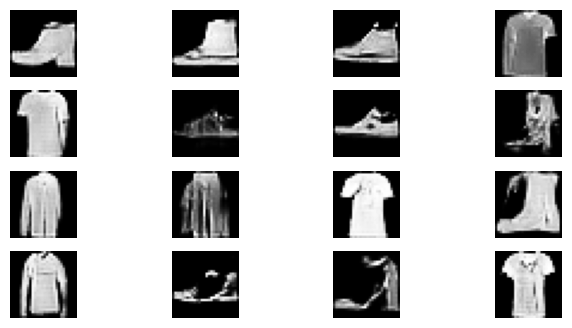

 50%|█████     | 25/50 [03:39<03:30,  8.43s/it]

Time for epoch 25: 8.307936191558838
Training started with epoch 26 with 469 batches
Losses after epoch    26: generator: 0.946, discriminator: 1.244, real_score: 100.51669311523438, fake_score: 40.64533615112305


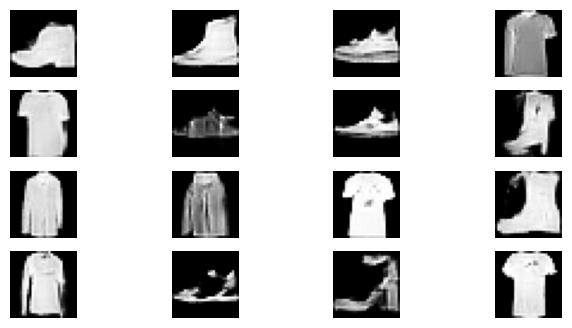

 52%|█████▏    | 26/50 [03:47<03:21,  8.39s/it]

Time for epoch 26: 8.296889543533325
Training started with epoch 27 with 469 batches
Losses after epoch    27: generator: 0.935, discriminator: 1.323, real_score: 100.50395965576172, fake_score: 42.367557525634766


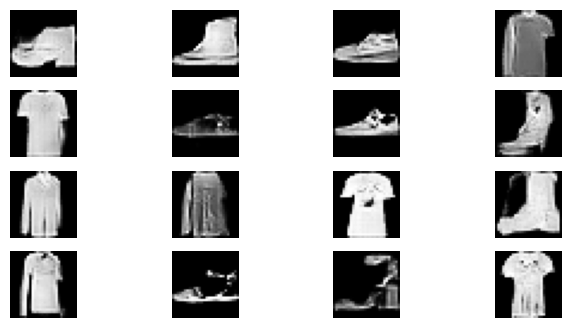

 54%|█████▍    | 27/50 [03:55<03:12,  8.36s/it]

Time for epoch 27: 8.28130578994751
Training started with epoch 28 with 469 batches
Losses after epoch    28: generator: 0.940, discriminator: 1.339, real_score: 100.49052429199219, fake_score: 42.01663589477539


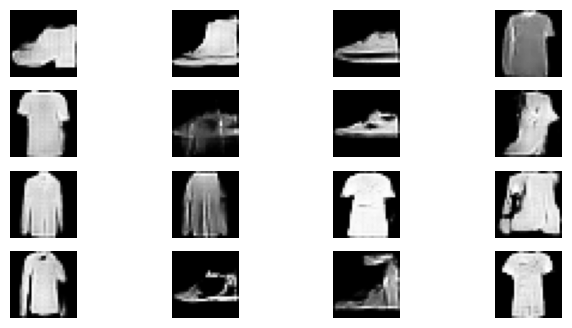

 56%|█████▌    | 28/50 [04:04<03:03,  8.34s/it]

Time for epoch 28: 8.30082893371582
Training started with epoch 29 with 469 batches
Losses after epoch    29: generator: 0.716, discriminator: 1.365, real_score: 100.56743621826172, fake_score: 50.90668869018555


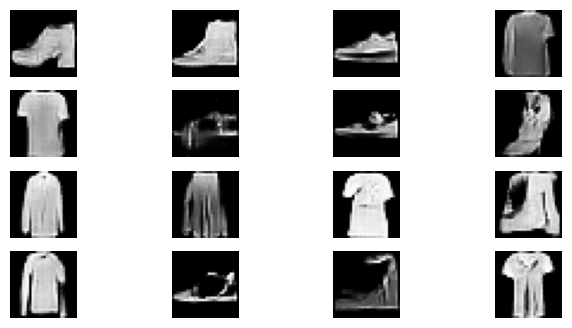

 58%|█████▊    | 29/50 [04:12<02:54,  8.33s/it]

Time for epoch 29: 8.290762186050415
Training started with epoch 30 with 469 batches
Losses after epoch    30: generator: 0.952, discriminator: 1.173, real_score: 100.56019592285156, fake_score: 41.18670654296875


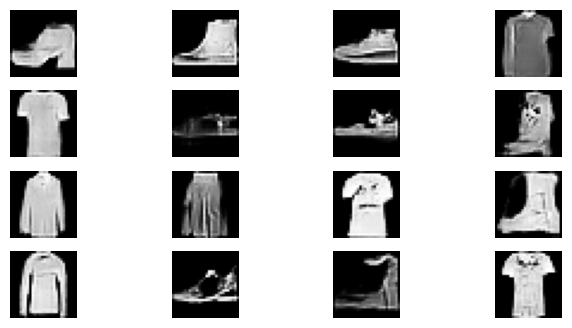

 60%|██████    | 30/50 [04:20<02:47,  8.35s/it]

Time for epoch 30: 8.403345584869385
Training started with epoch 31 with 469 batches
Losses after epoch    31: generator: 0.815, discriminator: 1.376, real_score: 100.50778198242188, fake_score: 46.676170349121094


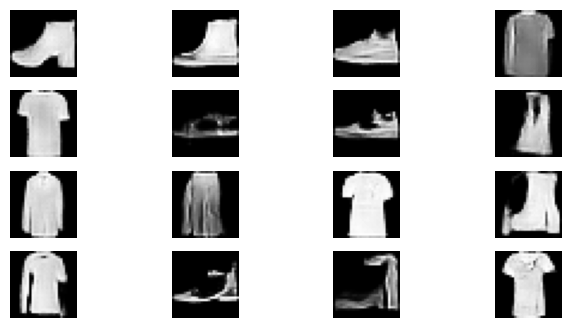

 62%|██████▏   | 31/50 [04:29<02:38,  8.33s/it]

Time for epoch 31: 8.284812688827515
Training started with epoch 32 with 469 batches
Losses after epoch    32: generator: 0.683, discriminator: 1.288, real_score: 100.63839721679688, fake_score: 52.80793380737305


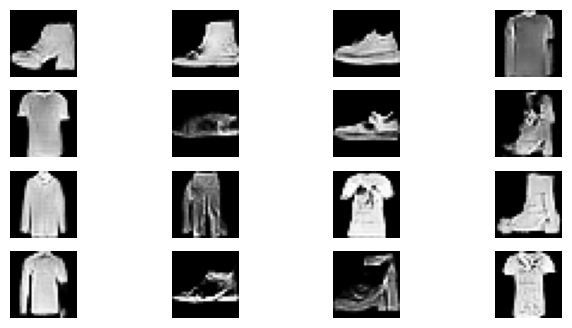

 64%|██████▍   | 32/50 [04:37<02:29,  8.32s/it]

Time for epoch 32: 8.298536777496338
Training started with epoch 33 with 469 batches
Losses after epoch    33: generator: 0.837, discriminator: 1.277, real_score: 100.55072784423828, fake_score: 45.46408462524414


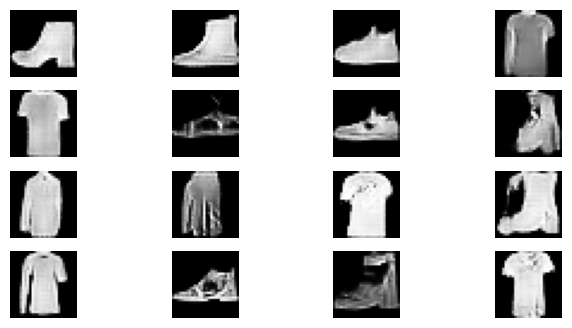

 66%|██████▌   | 33/50 [04:46<02:25,  8.55s/it]

Time for epoch 33: 9.075150966644287
Training started with epoch 34 with 469 batches
Losses after epoch    34: generator: 0.727, discriminator: 1.451, real_score: 100.50914001464844, fake_score: 50.3005256652832


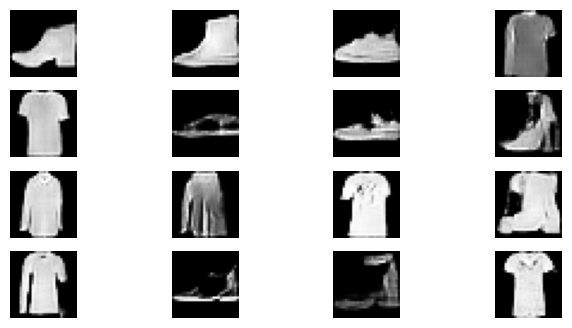

 68%|██████▊   | 34/50 [04:54<02:15,  8.47s/it]

Time for epoch 34: 8.277824640274048
Training started with epoch 35 with 469 batches
Losses after epoch    35: generator: 0.799, discriminator: 1.374, real_score: 100.51423645019531, fake_score: 47.064937591552734


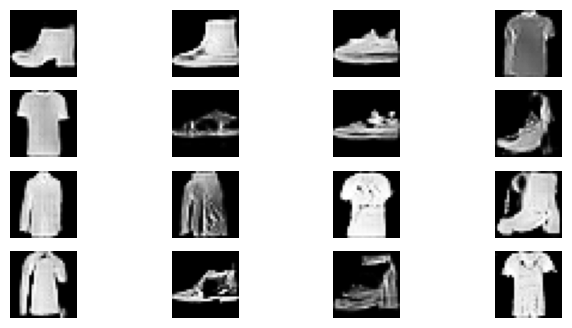

 70%|███████   | 35/50 [05:03<02:06,  8.42s/it]

Time for epoch 35: 8.304060697555542
Training started with epoch 36 with 469 batches
Losses after epoch    36: generator: 0.790, discriminator: 1.343, real_score: 100.53097534179688, fake_score: 47.39815139770508


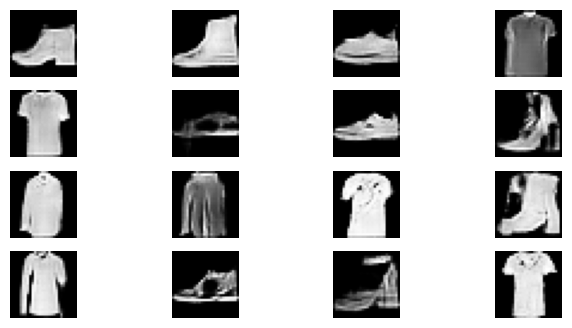

 72%|███████▏  | 36/50 [05:11<01:57,  8.39s/it]

Time for epoch 36: 8.312373161315918
Training started with epoch 37 with 469 batches
Losses after epoch    37: generator: 0.705, discriminator: 1.368, real_score: 100.57047271728516, fake_score: 51.76765441894531


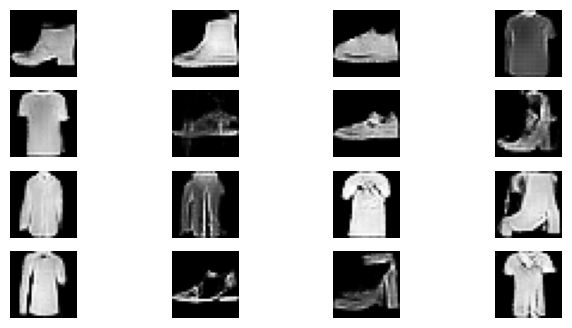

 74%|███████▍  | 37/50 [05:19<01:48,  8.36s/it]

Time for epoch 37: 8.290957689285278
Training started with epoch 38 with 469 batches
Losses after epoch    38: generator: 0.815, discriminator: 1.329, real_score: 100.52875518798828, fake_score: 46.388427734375


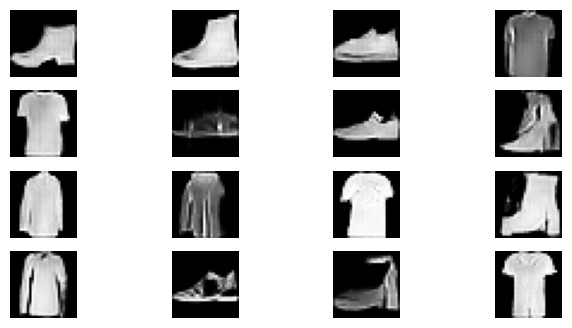

 76%|███████▌  | 38/50 [05:28<01:39,  8.33s/it]

Time for epoch 38: 8.262742519378662
Training started with epoch 39 with 469 batches
Losses after epoch    39: generator: 0.768, discriminator: 1.390, real_score: 100.51870727539062, fake_score: 48.53528594970703


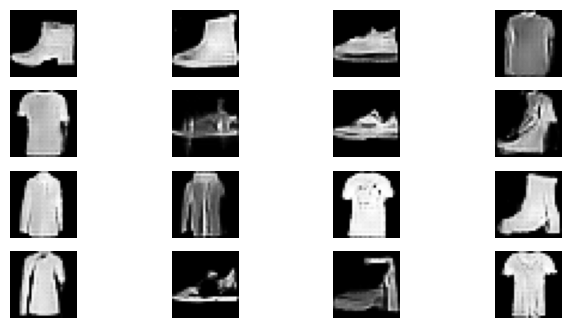

 78%|███████▊  | 39/50 [05:36<01:31,  8.31s/it]

Time for epoch 39: 8.260252475738525
Training started with epoch 40 with 469 batches
Losses after epoch    40: generator: 0.788, discriminator: 1.346, real_score: 100.5387191772461, fake_score: 47.7116584777832


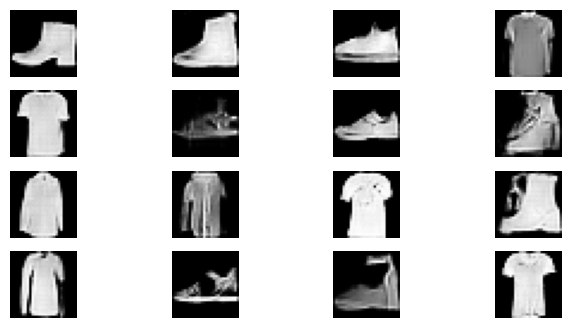

 80%|████████  | 40/50 [05:44<01:23,  8.33s/it]

Time for epoch 40: 8.388222217559814
Training started with epoch 41 with 469 batches
Losses after epoch    41: generator: 0.856, discriminator: 1.324, real_score: 100.51575469970703, fake_score: 44.50385665893555


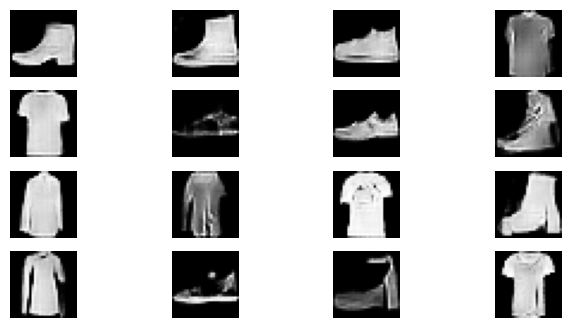

 82%|████████▏ | 41/50 [05:52<01:14,  8.31s/it]

Time for epoch 41: 8.264355182647705
Training started with epoch 42 with 469 batches
Losses after epoch    42: generator: 0.942, discriminator: 1.278, real_score: 100.51400756835938, fake_score: 41.20939636230469


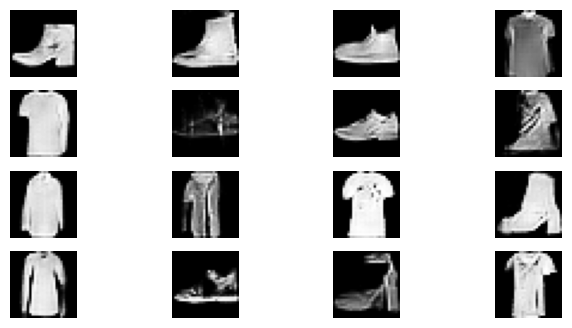

 84%|████████▍ | 42/50 [06:01<01:08,  8.52s/it]

Time for epoch 42: 9.016784191131592
Training started with epoch 43 with 469 batches
Losses after epoch    43: generator: 0.894, discriminator: 1.264, real_score: 100.52851867675781, fake_score: 42.925662994384766


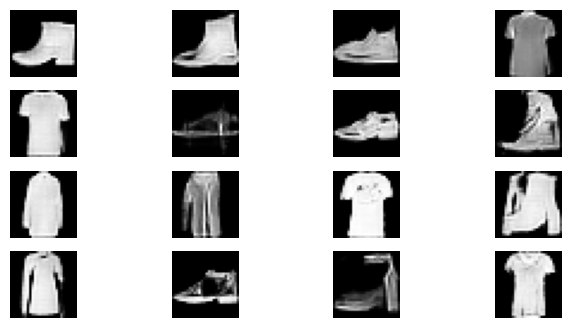

 86%|████████▌ | 43/50 [06:10<00:59,  8.45s/it]

Time for epoch 43: 8.266424894332886
Training started with epoch 44 with 469 batches
Losses after epoch    44: generator: 0.770, discriminator: 1.402, real_score: 100.50104522705078, fake_score: 47.725372314453125


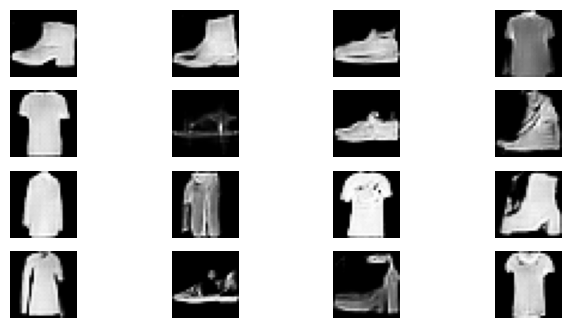

 88%|████████▊ | 44/50 [06:18<00:50,  8.39s/it]

Time for epoch 44: 8.26968240737915
Training started with epoch 45 with 469 batches
Losses after epoch    45: generator: 0.830, discriminator: 1.319, real_score: 100.5354995727539, fake_score: 46.238128662109375


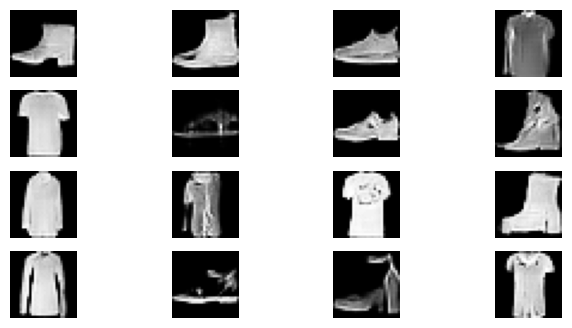

 90%|█████████ | 45/50 [06:26<00:41,  8.35s/it]

Time for epoch 45: 8.255028486251831
Training started with epoch 46 with 469 batches
Losses after epoch    46: generator: 0.836, discriminator: 1.358, real_score: 100.51168823242188, fake_score: 45.2726936340332


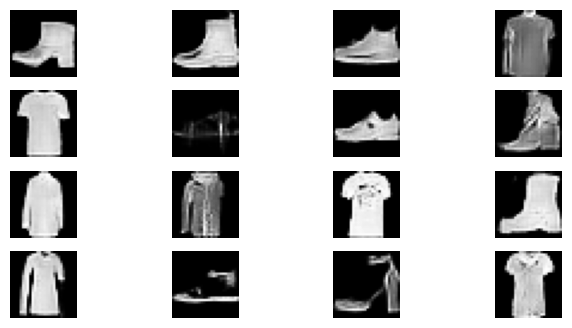

 92%|█████████▏| 46/50 [06:35<00:33,  8.33s/it]

Time for epoch 46: 8.27204942703247
Training started with epoch 47 with 469 batches
Losses after epoch    47: generator: 0.684, discriminator: 1.388, real_score: 100.56631469726562, fake_score: 52.85307312011719


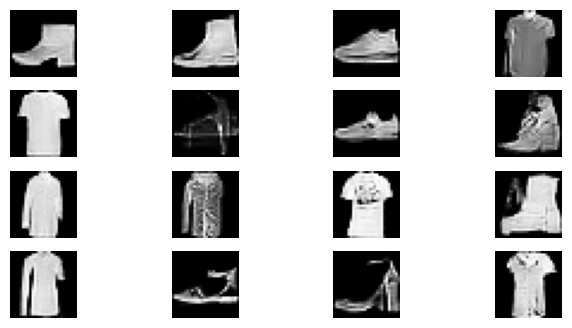

 94%|█████████▍| 47/50 [06:43<00:24,  8.31s/it]

Time for epoch 47: 8.260388612747192
Training started with epoch 48 with 469 batches
Losses after epoch    48: generator: 0.739, discriminator: 1.382, real_score: 100.54564666748047, fake_score: 50.10222244262695


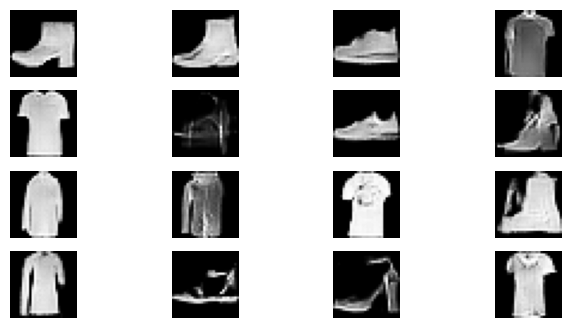

 96%|█████████▌| 48/50 [06:51<00:16,  8.29s/it]

Time for epoch 48: 8.256555557250977
Training started with epoch 49 with 469 batches
Losses after epoch    49: generator: 0.742, discriminator: 1.341, real_score: 100.54728698730469, fake_score: 49.33628845214844


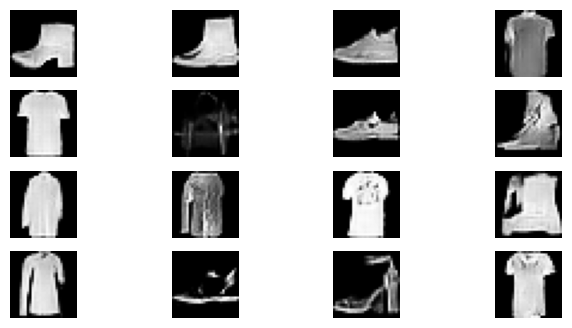

 98%|█████████▊| 49/50 [06:59<00:08,  8.29s/it]

Time for epoch 49: 8.266196727752686
Training started with epoch 50 with 469 batches
Losses after epoch    50: generator: 0.862, discriminator: 1.318, real_score: 100.50875091552734, fake_score: 43.99267578125


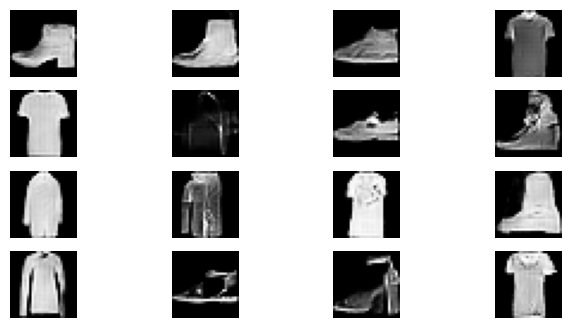

100%|██████████| 50/50 [07:08<00:00,  8.57s/it]

Time for epoch 50: 8.443914651870728


In [36]:
gen_loss_list, disc_loss_list, real_score_list, fake_score_list = train(train_dataset, epochs=epochs)

Text(0.5, 1.0, 'Accuracy scores')

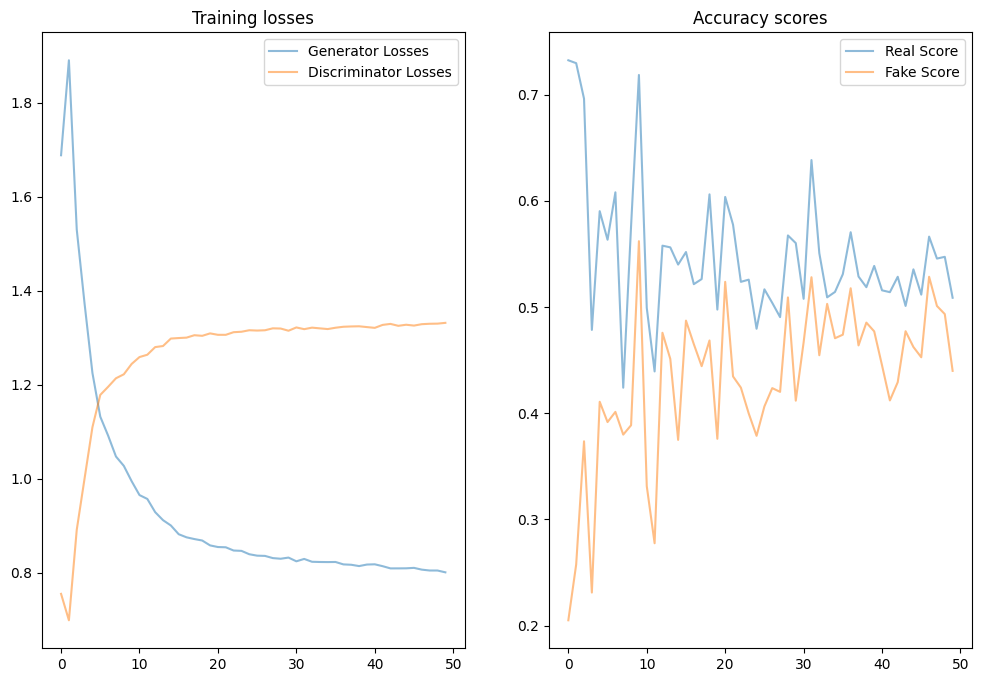

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.plot(gen_loss_list, label='Generator Losses', alpha=0.5)
ax1.plot(disc_loss_list, label='Discriminator Losses', alpha=0.5)
ax1.legend()
ax1.set_title('Training losses')
ax2.plot(real_score_list, label='Real Score', alpha=0.5)
ax2.plot(fake_score_list, label='Fake Score', alpha=0.5)
ax2.legend()
ax2.set_title('Accuracy scores')